In [81]:
# ================================================================
# Bachelor Thesis — Fairness in Toxic Comment Classification
# ---------------------------------------------------------------
# Notebook: fcl_model_training_and_evaluation.ipynb
# Author: Philipp Stocker
# Created: 06.12.2025
# Purpose: TODO: fill purpose
# ================================================================

# --- Basic setup ---
import os
import sys
import warnings
warnings.filterwarnings("ignore")  # keep output clean for reports

# Automatically add project root to path so src/ modules are importable
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Standard imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import joblib

from src.modeling import predict_with_model
from src.modeling import extract_feature_and_label_arrays
from src.modeling import find_best_threshold

from src.bias_mitigation import fit_fairness_constrained_pipeline
from src.bias_mitigation import _build_identity_group_labels

from src.data_preprocessing_and_preparation import reduce_dataset_size

from src.metrics import compute_overall_metrics
from src.metrics import evaluate_subgroups

from src.visualization import (
    plot_performance_bar,
    plot_roc_curve,
    plot_pr_curve,
    plot_confusion_matrix,
    plot_auc_bars,
    plot_rate_gaps_bars,
    print_small_sample_warnings
)

# --- "Global variables" ---
DATA_RAW = os.path.join(project_root, "data", "raw")
DATA_PROCESSED = os.path.join(project_root, "data", "processed")

IDENTITY_COLUMNS = ["male", "female", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "transgender", "other_gender", "other_sexual_orientation"]

print("✅ Environment ready")


✅ Environment ready


DATA PREPARATION

Load necessary, already existing data:

In [ ]:
# Load processed dataframe from parquet file
train_df_full = pd.read_parquet(os.path.join(DATA_PROCESSED, "train_processed.parquet"))
# Ensure that processed comment texts are strings and handle any missing values
train_df_full["comment_text_processed"] = train_df_full["comment_text_processed"].astype(str).fillna("")

# Reduce dataset size to ease ExponetiatedGradient training
train_df, _ = reduce_dataset_size(train_df_full, sample_size=500000, identity_cols=IDENTITY_COLUMNS, drop_index=False)

# Obtain best hyperparameters from base model training
base_models = joblib.load(project_root + "/models/tfidf_base_models.joblib")
best_params = base_models["best_params"]
base_models = None  # free up memory

# Load feature and label arrays
x_train, y_train = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "train_tfidf_bundle.joblib")))
x_train = x_train[train_df.index]  # align with reduced train_df
y_train = y_train[train_df.index]  # align with reduced train_df

x_val, y_val = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "val_threshold_tfidf_bundle.joblib")))
x_test, y_test = extract_feature_and_label_arrays(joblib.load(os.path.join(DATA_PROCESSED, "test_tfidf_bundle.joblib")))

lgbtq_identities = ["bisexual", "homosexual_gay_or_lesbian", "transgender"]

FCL MODEL TRAINING

Truncate data to lower-dimensional dense representation because ExponentiatedGradient expects dense data (for x_train) and original x_train caused a MemoryError (4.78 TiB needed):

In [83]:
# Dimensionality Reduction with TruncatedSVD
from sklearn.decomposition import TruncatedSVD

n_components = 512  # number of components for SVD
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit on sparse x_train and transform train, val, test sets
x_train_svd = svd.fit_transform(x_train)   # dense (n_samples, n_components)
x_val_svd   = svd.transform(x_val)
x_test_svd  = svd.transform(x_test)

# Cast to float32 to halve memory usage
x_train_svd = x_train_svd.astype(np.float32)
x_val_svd   = x_val_svd.astype(np.float32)
x_test_svd  = x_test_svd.astype(np.float32)

# Save the fitted SVD transformer
joblib.dump(svd, project_root + "/models/tfidf_svd_transformer_512.joblib")

['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/models/tfidf_svd_transformer_512.joblib']

Adapt the x-matrices to the truncated ones for further use:

In [84]:
x_train = x_train_svd
x_val = x_val_svd
x_test = x_test_svd

Do some checks on subgroup distribution (necessary because the constraint_type "DemographicParity" expects a higher sensitive feature distribution to converge to a result):

In [85]:
import pandas as pd

# Check group sizes in train_df
print("Group sizes:")
for col in lgbtq_identities:
    print(f"  {col}: {(train_df[col] >= 0.5).sum()} samples")

# Check if any group is empty or has only one class
sensitive_features = _build_identity_group_labels(train_df, lgbtq_identities)
print("\nSensitive feature group distribution:")
print(sensitive_features.value_counts())

# Check class balance within each group (should have both 0 and 1)
for group in sensitive_features.unique():
    mask = sensitive_features == group
    n_pos = (y_train[mask] == 1).sum()
    n_neg = (y_train[mask] == 0).sum()
    print(f"{group}: {n_pos} positive, {n_neg} negative")

Group sizes:
  bisexual: 82 samples
  homosexual_gay_or_lesbian: 3032 samples
  transgender: 680 samples

Sensitive feature group distribution:
identity_group
background                   496402
homosexual_gay_or_lesbian      2971
transgender                     545
bisexual                         82
Name: count, dtype: int64
background: 39745 positive, 456657 negative
homosexual_gay_or_lesbian: 237 positive, 2734 negative
transgender: 49 positive, 496 negative
bisexual: 11 positive, 71 negative


Train model with FCL as bias mitigation strategy using the tuned hyperparameters from the base model training:

Note: No calibration is used for this model.

In [66]:
# Train FCL model with BoundedGroupLoss constraint to handle imbalanced sensitive feature groups (bisexual: 42 samples)
# BoundedGroupLoss is more forgiving than DemographicParity for imbalanced groups, penalizing worst-off group rather than demanding equality
# upper_bound=0.3 (30% tolerance) is more lenient and suitable for severely imbalanced groups
# eg_max_iter=500 gives ExponentiatedGradient sufficient iterations to converge
fcl_model = fit_fairness_constrained_pipeline(
    train_df=train_df,
    x_train=x_train,
    y_train=y_train,
    identity_cols=lgbtq_identities,
    best_params=best_params,
    max_iter=5000,  # LogisticRegression iterations (5000 for convergence with fairness)
    constraint_type="bounded_group_loss",  # Use BoundedGroupLoss instead of DemographicParity for imbalanced groups
    upper_bound=0.2,  # 30% tolerance for loss difference between groups
    eg_max_iter=500  # ExponentiatedGradient iterations (increased from default 300 for convergence)
)

# Save as bundle to keep data structure consistent
fcl_model_bundle = {
    "model": fcl_model,
    "uncalibrated_model": None, # not applicable for fcl model
    "best_params": best_params
}

# Save trained fcl model
joblib.dump(fcl_model_bundle, project_root + "/models/tfidf_fcl_models.joblib")

['c:\\Users\\phili\\OneDrive\\Dokumente\\Uni\\Kurse\\7. Semester\\Bachelorarbeit\\BA_Arbeitsmappe\\BachelorThesis_BiasInToxicCommentClassification/models/tfidf_fcl_models.joblib']

FCL MODEL EVALUATION

Load fcl models for further evaluation

In [86]:
fcl_models = joblib.load(project_root + "/models/tfidf_fcl_models.joblib")

Calculate best threshold based on f1 score

In [87]:
y_val_proba, _ = predict_with_model(fcl_models["model"], x_val, threshold=0.5)

threshold = find_best_threshold(y_val, y_val_proba)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__slotnames__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_params_html', '_hs', '_html_repr', '_pmf_predict', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_params', 'best_gap_', 'best_iter_', 'constraints', 'eps', 'estimator', 'eta0', 'fit', 'get_metadata_routing', 'get_params', 'lambda_vecs_', 'lambda_vecs_EG_', 'lambda_vecs_LP_', 'last_iter_', 'max_iter',

Conduct prediction on test dataset and print result

In [88]:
y_test_proba, y_test_pred = predict_with_model(fcl_models["model"], x_test, threshold=threshold)

# Calculate and print number of toxic and non-toxic comments in test set
count_toxic = np.sum(y_test_pred)
count_nontoxic = len(y_test_pred) - count_toxic
print(f"Number of toxic comments: {count_toxic}")
print(f"Number of non-toxic comments: {count_nontoxic}")    

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_clone__', '__sklearn_tags__', '__slotnames__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_build_request_for_signature', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_get_default_requests', '_get_doc_link', '_get_metadata_request', '_get_param_names', '_get_params_html', '_hs', '_html_repr', '_pmf_predict', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_params', 'best_gap_', 'best_iter_', 'constraints', 'eps', 'estimator', 'eta0', 'fit', 'get_metadata_routing', 'get_params', 'lambda_vecs_', 'lambda_vecs_EG_', 'lambda_vecs_LP_', 'last_iter_', 'max_iter',

FCL MODEL PERFORMANCE METRICS

Calculate performance metrics

In [89]:
fcl_model_overall_metrics = compute_overall_metrics(y_test, y_test_pred, y_test_proba)

print("Overall metrics for fcl model:")
print(fcl_model_overall_metrics)

Overall metrics for fcl model:
{'accuracy': 0.8999191078967684, 'precision': 0.3597341028547872, 'recall': 0.3224331439656367, 'f1_score': 0.340063813722386, 'roc_auc': 0.7706931946030839, 'pr_auc': 0.3446475396484535}


Visualize performance metrics

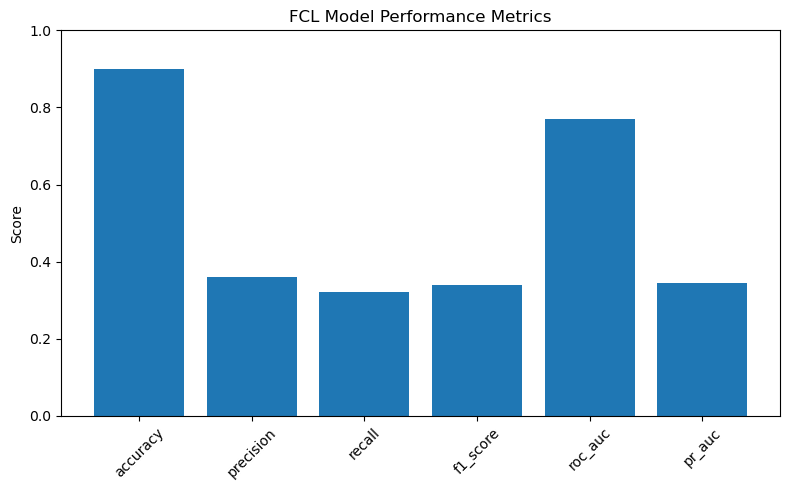

In [90]:
# Plot performance bars
plot_performance_bar(fcl_model_overall_metrics, title="FCL Model Performance Metrics")

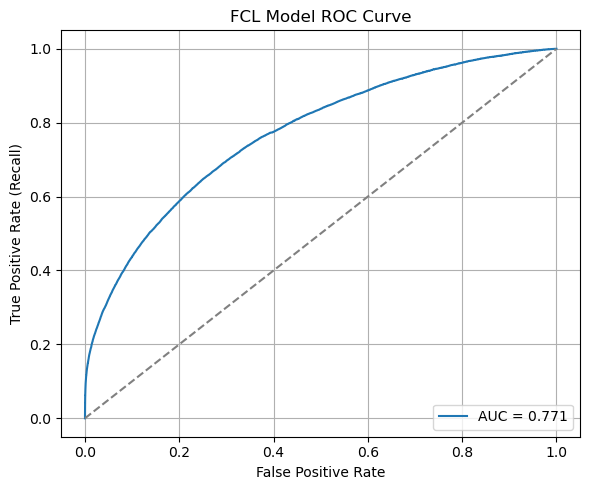

In [91]:
# Plot ROC curve
plot_roc_curve(y_test, y_test_proba, title="FCL Model ROC Curve")

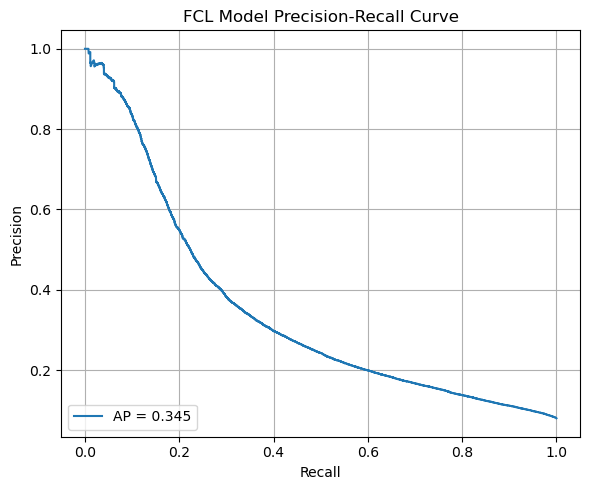

In [92]:
# Plot PR curve
plot_pr_curve(y_test, y_test_proba, title="FCL Model Precision-Recall Curve")

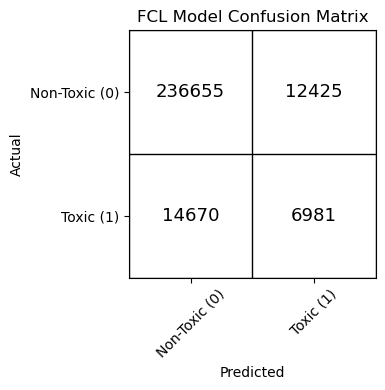

In [93]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred, title="FCL Model Confusion Matrix")

BASE MODEL FAIRNESS METRICS

Calculate fairness Metrics (per subgroup)

In [94]:
# Prepare test dataframe with predictions for subgroup evaluation
test_df = pd.read_parquet(os.path.join(DATA_PROCESSED, "test_processed.parquet")).copy()
test_df["predicted_proba"] = y_test_proba
test_df["predicted_label"] = y_test_pred

test_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,labelled_as_toxic,has_identity,comment_text_processed,predicted_proba,predicted_label
0,5555389,0.1,I listened to Scheer re Omar Khadr; he sounded...,0.0,0.0,0.1,0.1,0.0,NaN,NaN,...,3,2,0.0,0,10,0,0,i listened to scheer re omar khadr he sounded ...,0.924569,1
1,376072,0.0,For more on Pre check out; prespeople.com,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0.0,0,4,0,0,for more on pre check out prespeople com,0.005433,0
2,539767,0.4,They also have to go to places where people sh...,0.1,0.0,0.0,0.0,0.4,NaN,NaN,...,0,0,0.0,0,10,0,0,they also have to go to places where people sh...,0.451588,0
3,5556650,0.0,This is why many experts and policy makers are...,0.0,0.0,0.2,0.0,0.0,NaN,NaN,...,0,0,0.0,0,5,0,0,this is why many experts and policy makers are...,0.863381,1
4,333126,0.0,"Yeah, I know...many regular miles as well.",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0.0,0,4,0,0,yeah i know many regular miles as well,0.138282,0


In [95]:
# Conduct subgroup evaluation
subgroup_metrics_df = evaluate_subgroups(
    df=test_df,
    subgroup_cols=IDENTITY_COLUMNS,
    threshold=threshold
)

In [96]:
print(subgroup_metrics_df)

                    subgroup  n_subgroup    n_bg  n_sg_pos  n_sg_neg  \
0               heterosexual         189  270542        37       152   
1                   bisexual          38  270693         6        32   
2  homosexual_gay_or_lesbian        1604  269127       454      1150   
3                transgender         353  270378        88       265   
4                     female        8107  262624      1093      7014   
5                       male        6640  264091       985      5655   
6               other_gender           1  270730         0         1   
7   other_sexual_orientation           3  270728         3         0   

   subgroup_auc  bpsn_auc  bnsp_auc    sg_fpr    sg_fnr    bg_fpr    bg_fnr  \
0      0.618599  0.675791  0.725434  0.078947  0.810811  0.049866  0.677339   
1      0.625000  0.748849  0.663310  0.031250  0.833333  0.049886  0.677524   
2      0.654344  0.688637  0.748760  0.082609  0.786344  0.049732  0.675237   
3      0.714365  0.757419  0.728617

Visualize fairness metrics (per subgroup)

In [97]:
# Print warnings indicating subgroups with small sample sizes
# This helps to identify potential issues with metric stability due to limited data
print_small_sample_warnings(subgroup_metrics_df)

[WARN] bisexual: small sample -> n_subgroup=38
[WARN] other_gender: small sample -> n_subgroup=1, n_sg_pos=0, n_sg_neg=1
[WARN] other_sexual_orientation: small sample -> n_subgroup=3, n_sg_pos=3, n_sg_neg=0


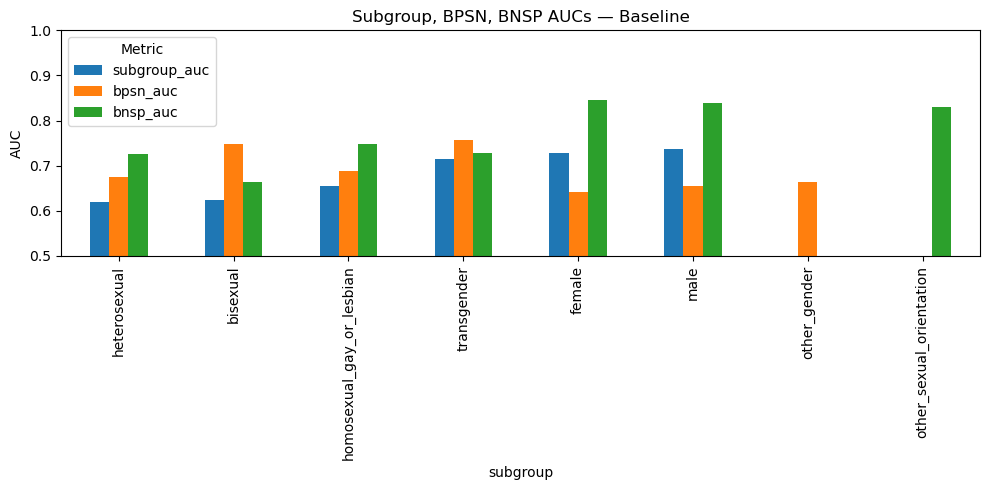

In [98]:
# Visualize auc bars
plot_auc_bars(subgroup_metrics_df)

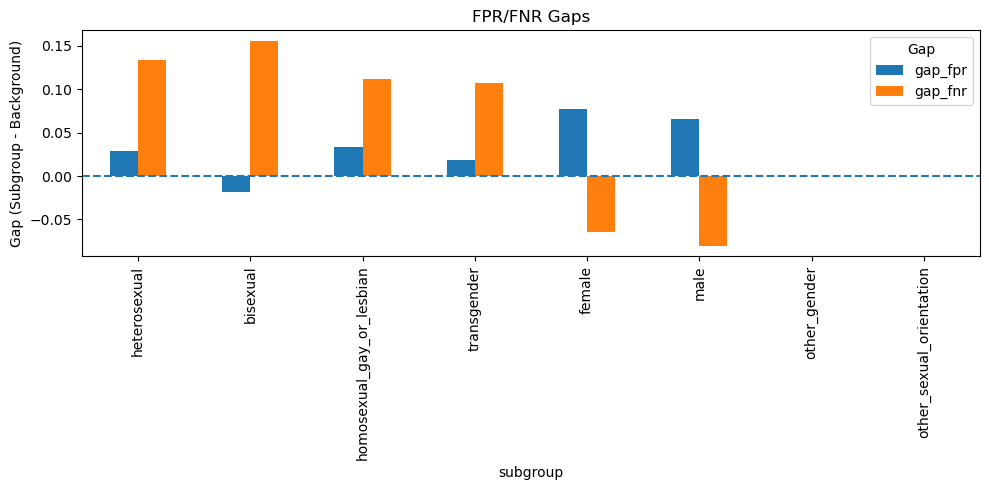

In [99]:
# Visualize fpr/fnr gaps bars
plot_rate_gaps_bars(subgroup_metrics_df)